# Bandit on Linear Graphs

In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import pickle as pkl
from networkx.generators.random_graphs import path_graph


from reward import GaussianReward
from agent import LocalThompsonSamplingAgent,LocalUCBAgent, LocalRandomWalkAgent,Agent,MultiStepLookAheadAgent
from estimator import NormalBayesianEstimator
%load_ext autoreload
%autoreload 2

In [20]:
# Main Loop
def main(G,agent,T=1000):
#     s_0 = np.random.choice(G.nodes)
    s_0 = 0
    s = s_0

    s_hist = []
    r_hist = []

    for t in range(T):
        r = G.nodes[s]['reward_sampler'].sample()
        agent.update(s,r)

        r_hist.append(r)
        s_hist.append(s)

        s = agent.next_s()
    return s_hist, r_hist

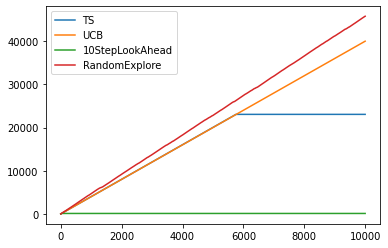

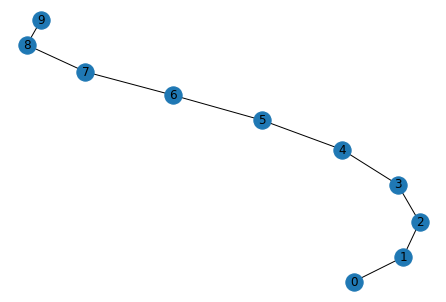

In [43]:
N_nodes = 10
p_edge_form = 0.7
k_neighbors = 2
G = path_graph(N_nodes)
G_no_sampler = G.copy()

# Initialize reward sampler for each node.
# mus = np.linspace(0,2,N_nodes)
# sigs = np.ones(N_nodes)*0.5

mus = np.zeros(N_nodes)
mus[-1]=5
mus[1]=1
sigs = np.ones(N_nodes)*0.5
for n in G.nodes:
    G.nodes[n]['reward_sampler'] = GaussianReward(mus[n],sigs[n])
    
T=10000
lookahead = 10

TS_agent = LocalThompsonSamplingAgent(G_no_sampler,m=50,epsilon=0.01)
UCB_agent = LocalUCBAgent(G_no_sampler,beta=0.5,m=50,epsilon=0.01)
lookahead_agent = MultiStepLookAheadAgent(G_no_sampler,T=lookahead,m=50,epsilon=0.01,merit='TS')

control = LocalRandomWalkAgent(G_no_sampler)

s_look,_ = main(G,lookahead_agent,T)
s_TS,_ = main(G,TS_agent,T)
s_UCB,_ = main(G,UCB_agent,T)
s_control,_ = main(G,control,T)

r_star = np.max(mus)
s_star = np.argmax(mus)

steps = r_star-mus[np.array(s_look)]
look_regret = np.cumsum(steps)

steps = r_star-mus[np.array(s_TS)]
TS_regret = np.cumsum(steps)

steps = r_star-mus[np.array(s_UCB)]
UCB_regret = np.cumsum(steps)


steps = r_star-mus[np.array(s_control)]
control_regret = np.cumsum(steps)


plt.plot(TS_regret,label='TS')
plt.plot(UCB_regret,label='UCB')
plt.plot(look_regret,label='{}StepLookAhead'.format(lookahead))

plt.plot(control_regret,label='RandomExplore')
plt.legend()

plt.show()

labels = {n:n for n in G.nodes}
nx.draw(G,labels=labels)
plt.show()

In [44]:
print('True reward parameters:')
for i,(mu,sig) in enumerate(zip(mus,sigs)):
    print(i,mu)

True reward parameters:
0 0.0
1 1.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 5.0
